In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 1. PREPARE DATA

## 1.1. Read data

In [2]:
data_df = pd.read_excel(
    'lg_innotek_ok_ng_dataset/ng_ok_step_figure_dataset/ng_ok_data.xlsx',
    engine='openpyxl',
    sheet_name=0
)
data_df = data_df.rename(columns={'Unnamed: 0': 'ID'})
data_df

,ID,Step,A,B,C,D,E
0,7143PLGJH1SS2D097SS2D0,0,0.588352,0.564350,0.546382,0.533616,0.413290
1,7143PLGJH1SS2D097SS2D0,0,0.050891,0.042886,0.053276,0.034690,0.024467
2,7143PLGJH1SS2D097SS2D0,1,0.056249,0.047645,0.055940,0.039808,0.024974
3,7143PLGJH1SS2D097SS2D0,2,0.057846,0.048524,0.056475,0.040798,0.025394
4,7143PLGJH1SS2D097SS2D0,3,0.045904,0.026095,0.054595,0.056979,0.036955
...,...,...,...,...,...,...,...
3800,344125EJH4SS7D103SS7D1,8,0.385173,0.344588,0.369460,0.341547,0.360278
3801,344125EJH4SS7D103SS7D1,9,0.303972,0.290504,0.344147,0.283809,0.350768
3802,344125EJH4SS7D103SS7D1,10,0.271701,0.226380,0.301759,0.227052,0.332305
3803,344125EJH4SS7D103SS7D1,11,0.221545,0.178121,0.261385,0.180707,0.298866


In [3]:
label_df = pd.read_excel(
    'lg_innotek_ok_ng_dataset/ng_ok_step_figure_dataset/ng_ok_data.xlsx',
    engine='openpyxl',
    sheet_name=1
)
label_df

,ID,Label,Remark
0,7143PLGJH1SS2D097SS2D0,NG,NaN
1,70D3M9GHH1SS2D097SS2D0,NG,Type 2
2,70F3NFGHH1SS2D097SS2D0,NG,Type 2
3,70E402GGH1SS2D097SS2D0,NG,Type 2
4,714407GKH1SS2D097SS2D0,NG,Type 2
...,...,...,...
199,34411CEJH4SS7D103SS7D1,OK,NaN
200,34311BEMH4SS7D103SS7D1,OK,NaN
201,345113EMH4SS7D103SS7D1,OK,NaN
202,345110EKH4SS7D103SS7D1,OK,NaN


## 1.2. Prepare feature

In [4]:
grouped_data_df = data_df.groupby(by='ID').agg(list).reset_index()
grouped_data_df

,ID,Step,A,B,C,D,E
0,34311BEMH4SS7D103SS7D1,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0.018876, 0.058013, 0.089152, 0.068431, 0.142...","[0.020959, 0.07472, 0.084353, 0.023753, 0.1717...","[0.013274, 0.05426, 0.066072, 0.061802, 0.1241...","[0.012564, 0.033984, 0.077574, 0.060829, 0.095...","[0.015833, 0.027841, 0.043242, 0.068583, 0.090..."
1,34311JEKH4SS7D103SS7D1,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0.028912, 0.058278, 0.091492, 0.066836, 0.156...","[0.052218, 0.083234, 0.079813, 0.050558, 0.185...","[0.01822, 0.051073, 0.070115, 0.056665, 0.1104...","[0.025158, 0.052283, 0.078907, 0.048965, 0.129...","[0.012249, 0.032187, 0.07584, 0.065415, 0.0709..."
2,34312BELH4SS7D103SS7D1,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0.034515, 0.058238, 0.045573, 0.103853, 0.244...","[0.019565, 0.050983, 0.017371, 0.140461, 0.299...","[0.02526, 0.066125, 0.048891, 0.074358, 0.2160...","[0.01465, 0.050217, 0.038474, 0.118546, 0.2559...","[0.023303, 0.046745, 0.052232, 0.064218, 0.162..."
3,34312CEMH4SS7D103SS7D1,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8]","[0.033997, 0.058677, 0.072719, 0.176351, 0.327...","[0.035283, 0.06126, 0.025285, 0.139149, 0.3010...","[0.027487, 0.055639, 0.077554, 0.159784, 0.268...","[0.035839, 0.064169, 0.059074, 0.158542, 0.321...","[0.024741, 0.051568, 0.101791, 0.187416, 0.305..."
4,34312FEKH4SS7D103SS7D1,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...","[0.03822, 0.070557, 0.066806, 0.032868, 0.1943...","[0.031319, 0.074344, 0.076803, 0.059709, 0.153...","[0.029055, 0.058664, 0.086159, 0.039429, 0.112...","[0.030228, 0.05369, 0.067952, 0.043953, 0.1122..."
...,...,...,...,...,...,...,...
202,75A3LFEMH4SSAD097SSAD0,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[0.077545, 0.085346, 0.087338, 0.087534, 0.052...","[0.151455, 0.060518, 0.055163, 0.057854, 0.037...","[0.123937, 0.064376, 0.065338, 0.066669, 0.035...","[0.10284, 0.075793, 0.079067, 0.082572, 0.0489...","[0.09983, 0.076387, 0.074205, 0.067191, 0.0405..."
203,75A3M0ELH4SSAD097SSAD0,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...","[0.042007, 0.0658, 0.062798, 0.059485, 0.05792...","[0.04235, 0.029421, 0.034642, 0.033375, 0.0302...","[0.04102, 0.059365, 0.063467, 0.060262, 0.0663...","[0.067956, 0.032593, 0.030283, 0.029825, 0.038..."
204,75A3M8EJH4SSAD097SSAD0,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[0.075911, 0.087448, 0.079928, 0.076893, 0.045...","[0.062392, 0.051936, 0.049361, 0.044433, 0.034...","[0.050325, 0.05881, 0.067336, 0.070062, 0.0642...","[0.066195, 0.037249, 0.036933, 0.038226, 0.058...","[0.058008, 0.073301, 0.078608, 0.078484, 0.052..."
205,75A3MNELH4SSAD097SSAD0,"[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[0.049516, 0.075042, 0.074886, 0.077547, 0.059...","[0.055373, 0.064519, 0.060896, 0.059829, 0.042...","[0.044855, 0.058113, 0.06035, 0.057738, 0.0517...","[0.051251, 0.057977, 0.060058, 0.048128, 0.046...","[0.044419, 0.061807, 0.06691, 0.063838, 0.0432..."


In [5]:
grouped_data_df['feature'] = grouped_data_df[['A', 'B', 'C', 'D', 'E']].apply(
    lambda all_features: [
        step_value for feature in all_features for step_value in feature
    ],
    axis=1
)
grouped_data_df['len_feature'] = grouped_data_df.feature.apply(len)
grouped_data_df = grouped_data_df.drop(
    columns=['Step', 'A', 'B', 'C', 'D', 'E']
)
grouped_data_df

,ID,feature,len_feature
0,34311BEMH4SS7D103SS7D1,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",65
1,34311JEKH4SS7D103SS7D1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",60
2,34312BELH4SS7D103SS7D1,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",60
3,34312CEMH4SS7D103SS7D1,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",50
4,34312FEKH4SS7D103SS7D1,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",65
...,...,...,...
202,75A3LFEMH4SSAD097SSAD0,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",70
203,75A3M0ELH4SSAD097SSAD0,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",75
204,75A3M8EJH4SSAD097SSAD0,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",70
205,75A3MNELH4SSAD097SSAD0,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",70


In [6]:
max_len_feature = np.max(grouped_data_df.len_feature)
max_len_feature

175

In [7]:
grouped_data_df.len_feature.value_counts()

len_feature
65     33
70     31
95     20
100    16
60     15
90     11
105    10
55      9
110     8
130     7
125     6
135     6
145     5
75      4
150     4
50      4
120     3
140     3
165     3
115     3
175     2
155     2
160     2
Name: count, dtype: int64

In [8]:
df = pd.merge(grouped_data_df, label_df, how='inner', on='ID')
df

,ID,feature,len_feature,Label,Remark
0,34311BEMH4SS7D103SS7D1,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",65,OK,NaN
1,34311JEKH4SS7D103SS7D1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",60,OK,NaN
2,34312BELH4SS7D103SS7D1,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",60,OK,NaN
3,34312CEMH4SS7D103SS7D1,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",50,OK,NaN
4,34312FEKH4SS7D103SS7D1,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",65,OK,NaN
...,...,...,...,...,...
199,75A3LFEMH4SSAD097SSAD0,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",70,OK,NaN
200,75A3M0ELH4SSAD097SSAD0,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",75,OK,NaN
201,75A3M8EJH4SSAD097SSAD0,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",70,OK,NaN
202,75A3MNELH4SSAD097SSAD0,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",70,OK,NaN


In [9]:
df.feature = df[['feature', 'len_feature']].apply(
    lambda x: x[0] + [0 for _ in range(max_len_feature - x[1])],
    axis=1
)
df.len_feature = df.feature.apply(len)
df

/var/folders/8_/m50_8s_942q571m12vh47_q80000gq/T/ipykernel_23770/2107110842.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: x[0] + [0 for _ in range(max_len_feature - x[1])],


,ID,feature,len_feature,Label,Remark
0,34311BEMH4SS7D103SS7D1,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",175,OK,NaN
1,34311JEKH4SS7D103SS7D1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",175,OK,NaN
2,34312BELH4SS7D103SS7D1,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",175,OK,NaN
3,34312CEMH4SS7D103SS7D1,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",175,OK,NaN
4,34312FEKH4SS7D103SS7D1,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",175,OK,NaN
...,...,...,...,...,...
199,75A3LFEMH4SSAD097SSAD0,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",175,OK,NaN
200,75A3M0ELH4SSAD097SSAD0,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",175,OK,NaN
201,75A3M8EJH4SSAD097SSAD0,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",175,OK,NaN
202,75A3MNELH4SSAD097SSAD0,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",175,OK,NaN


## 1.3. Prepare label

In [10]:
df = df.fillna({'Remark': '-1'})
df

,ID,feature,len_feature,Label,Remark
0,34311BEMH4SS7D103SS7D1,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",175,OK,-1
1,34311JEKH4SS7D103SS7D1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",175,OK,-1
2,34312BELH4SS7D103SS7D1,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",175,OK,-1
3,34312CEMH4SS7D103SS7D1,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",175,OK,-1
4,34312FEKH4SS7D103SS7D1,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",175,OK,-1
...,...,...,...,...,...
199,75A3LFEMH4SSAD097SSAD0,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",175,OK,-1
200,75A3M0ELH4SSAD097SSAD0,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",175,OK,-1
201,75A3M8EJH4SSAD097SSAD0,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",175,OK,-1
202,75A3MNELH4SSAD097SSAD0,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",175,OK,-1


In [11]:
def prepare_binary_classification_label(info):
    return 0 if info['Label'] == 'OK' else 1

In [12]:
def prepare_multi_class_classification_label(info):
    if info['Label'] == 'OK':
        return 0
    elif info['Label'] == 'NG':
        if info['Remark'] != '-1':
            return int(info['Remark'][-1])
        else:
            return -1

In [13]:
df['binary_label'] = df[['Label', 'Remark']].apply(
    prepare_binary_classification_label,
    axis=1
)

In [14]:
df['multi_class_label'] = df[['Label', 'Remark']].apply(
    prepare_multi_class_classification_label,
    axis=1
)

In [15]:
df

,ID,feature,len_feature,Label,Remark,binary_label,multi_class_label
0,34311BEMH4SS7D103SS7D1,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",175,OK,-1,0,0
1,34311JEKH4SS7D103SS7D1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",175,OK,-1,0,0
2,34312BELH4SS7D103SS7D1,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",175,OK,-1,0,0
3,34312CEMH4SS7D103SS7D1,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",175,OK,-1,0,0
4,34312FEKH4SS7D103SS7D1,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",175,OK,-1,0,0
...,...,...,...,...,...,...,...
199,75A3LFEMH4SSAD097SSAD0,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",175,OK,-1,0,0
200,75A3M0ELH4SSAD097SSAD0,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",175,OK,-1,0,0
201,75A3M8EJH4SSAD097SSAD0,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",175,OK,-1,0,0
202,75A3MNELH4SSAD097SSAD0,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",175,OK,-1,0,0


In [16]:
df.binary_label.value_counts()

binary_label
1    103
0    101
Name: count, dtype: int64

In [17]:
df.multi_class_label.value_counts()

multi_class_label
 0    101
 2     97
 1      5
-1      1
Name: count, dtype: int64

In [18]:
binary_df = df[['feature', 'binary_label']]
binary_df

,feature,binary_label
0,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",0
1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",0
2,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",0
3,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",0
4,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",0
...,...,...
199,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",0
200,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",0
201,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",0
202,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",0


In [19]:
multi_class_df = df[['feature', 'multi_class_label']]
multi_class_df = multi_class_df[multi_class_df.multi_class_label != -1]
multi_class_df

,feature,multi_class_label
0,"[0.018876, 0.058013, 0.089152, 0.068431, 0.142...",0
1,"[0.028912, 0.058278, 0.091492, 0.066836, 0.156...",0
2,"[0.034515, 0.058238, 0.045573, 0.103853, 0.244...",0
3,"[0.033997, 0.058677, 0.072719, 0.176351, 0.327...",0
4,"[0.048112, 0.07916, 0.080094, 0.054201, 0.1936...",0
...,...,...
199,"[0.077545, 0.085346, 0.087338, 0.087534, 0.052...",0
200,"[0.068732, 0.044057, 0.044852, 0.05198, 0.0572...",0
201,"[0.075911, 0.087448, 0.079928, 0.076893, 0.045...",0
202,"[0.049516, 0.075042, 0.074886, 0.077547, 0.059...",0


# 2. SPLIT DATA INTO TRAIN SET AND VAL SET

## 2.1. Binary classification data

In [20]:
binary_df = binary_df.sample(frac=1, random_state=1)
multi_class_df = multi_class_df.sample(frac=1, random_state=1)

In [21]:
binary_df

,feature,binary_label
127,"[0.535333, 0.043186, 0.045916, 0.050854, 0.063...",1
203,"[0.048893, 0.067376, 0.072774, 0.069312, 0.080...",0
18,"[0.043665, 0.046353, 0.085347, 0.070402, 0.116...",0
175,"[0.122505, 0.071583, 0.070109, 0.060757, 0.039...",0
196,"[0.063541, 0.074936, 0.073245, 0.070832, 0.046...",0
...,...,...
133,"[0.582731, 0.063073, 0.068967, 0.071604, 0.052...",1
137,"[0.598603, 0.050257, 0.050297, 0.045689, 0.059...",1
72,"[0.486722, 0.034657, 0.032115, 0.036082, 0.039...",1
140,"[0.63131, 0.04949, 0.049873, 0.052852, 0.04608...",1


In [22]:
multi_class_df

,feature,multi_class_label
175,"[0.122505, 0.071583, 0.070109, 0.060757, 0.039...",0
176,"[0.074648, 0.074276, 0.073163, 0.0695, 0.04317...",0
18,"[0.043665, 0.046353, 0.085347, 0.070402, 0.116...",0
59,"[0.465337, 0.067762, 0.068347, 0.064832, 0.069...",2
143,"[0.621599, 0.065458, 0.060247, 0.065253, 0.071...",2
...,...,...
133,"[0.582731, 0.063073, 0.068967, 0.071604, 0.052...",2
137,"[0.598603, 0.050257, 0.050297, 0.045689, 0.059...",2
72,"[0.486722, 0.034657, 0.032115, 0.036082, 0.039...",2
140,"[0.63131, 0.04949, 0.049873, 0.052852, 0.04608...",1


In [23]:
train_val_pct = 0.25

In [24]:
X_binary = np.array(binary_df.feature.to_list())
X_binary

array([[0.535333, 0.043186, 0.045916, ..., 0.      , 0.      , 0.      ],
       [0.048893, 0.067376, 0.072774, ..., 0.      , 0.      , 0.      ],
       [0.043665, 0.046353, 0.085347, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.486722, 0.034657, 0.032115, ..., 0.      , 0.      , 0.      ],
       [0.63131 , 0.04949 , 0.049873, ..., 0.      , 0.      , 0.      ],
       [0.025553, 0.049748, 0.089849, ..., 0.      , 0.      , 0.      ]])

In [25]:
X_train_binary = X_binary[:round(train_val_pct * X_binary.shape[0]), :]
X_val_binary = X_binary[round(train_val_pct * X_binary.shape[0]):, :]

X_binary.shape, X_train_binary.shape, X_val_binary.shape

((204, 175), (51, 175), (153, 175))

In [26]:
y_binary = np.array(binary_df.binary_label.to_list())
y_binary

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0])

In [27]:
y_train_binary = y_binary[:round(train_val_pct * y_binary.shape[0])]
y_val_binary = y_binary[round(train_val_pct * y_binary.shape[0]):]

y_binary.shape, y_train_binary.shape, y_val_binary.shape

((204,), (51,), (153,))

## 2.2. Multi-class classification data

In [28]:
multi_class_df

,feature,multi_class_label
175,"[0.122505, 0.071583, 0.070109, 0.060757, 0.039...",0
176,"[0.074648, 0.074276, 0.073163, 0.0695, 0.04317...",0
18,"[0.043665, 0.046353, 0.085347, 0.070402, 0.116...",0
59,"[0.465337, 0.067762, 0.068347, 0.064832, 0.069...",2
143,"[0.621599, 0.065458, 0.060247, 0.065253, 0.071...",2
...,...,...
133,"[0.582731, 0.063073, 0.068967, 0.071604, 0.052...",2
137,"[0.598603, 0.050257, 0.050297, 0.045689, 0.059...",2
72,"[0.486722, 0.034657, 0.032115, 0.036082, 0.039...",2
140,"[0.63131, 0.04949, 0.049873, 0.052852, 0.04608...",1


In [29]:
train_val_pct = 0.5

In [30]:
X_multi_class = np.array(multi_class_df.feature.to_list())
X_multi_class

array([[0.122505, 0.071583, 0.070109, ..., 0.      , 0.      , 0.      ],
       [0.074648, 0.074276, 0.073163, ..., 0.      , 0.      , 0.      ],
       [0.043665, 0.046353, 0.085347, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.486722, 0.034657, 0.032115, ..., 0.      , 0.      , 0.      ],
       [0.63131 , 0.04949 , 0.049873, ..., 0.      , 0.      , 0.      ],
       [0.025553, 0.049748, 0.089849, ..., 0.      , 0.      , 0.      ]])

In [31]:
X_train_multi_class = X_multi_class[:round(train_val_pct * X_multi_class.shape[0]), :]
X_val_multi_class = X_multi_class[round(train_val_pct * X_multi_class.shape[0]):, :]

X_multi_class.shape, X_train_multi_class.shape, X_val_multi_class.shape

((203, 175), (102, 175), (101, 175))

In [32]:
y_multi_class = np.array(multi_class_df.multi_class_label.to_list())
y_multi_class

array([0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0,
       2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2,
       0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 0])

In [33]:
y_train_multi_class = y_multi_class[:round(train_val_pct * y_multi_class.shape[0])]
y_val_multi_class = y_multi_class[round(train_val_pct * y_multi_class.shape[0]):]

y_multi_class.shape, y_train_multi_class.shape, y_val_multi_class.shape

((203,), (102,), (101,))

In [34]:
y_train_multi_class

array([0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0,
       2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2])

In [35]:
def convert_label_to_one_hot(label):
    one_hot_label = []
    for l in label:
        if l == 0:
            one_hot_label.append([1, 0, 0])
        elif l == 1:
            one_hot_label.append([0, 1, 0])
        elif l == 2:
            one_hot_label.append([0, 0, 1])
    return np.array(one_hot_label)

In [36]:
y_train_multi_class_one_hot = convert_label_to_one_hot(y_train_multi_class)
y_val_multi_class_one_hot = convert_label_to_one_hot(y_val_multi_class)

y_train_multi_class_one_hot.shape, y_val_multi_class_one_hot.shape

((102, 3), (101, 3))

# 3. Build and train simple Machine Learning model

## 3.1. Binary classification data

In [37]:
lr_binary_model = LogisticRegression()

In [38]:
lr_binary_model.fit(X_train_binary, y_train_binary)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [39]:
y_pred_binary = lr_binary_model.predict(X_val_binary)
y_pred_binary

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [40]:
y_val_binary

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [41]:
print(classification_report(y_val_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.99      0.99        81

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



## 3.2. Multi-class classification data

In [42]:
lr_multi_class_model = LogisticRegression(class_weight='balanced')

In [43]:
lr_multi_class_model.fit(X_train_multi_class, y_train_multi_class)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [44]:
y_pred_multi_class = lr_multi_class_model.predict(X_val_multi_class)
y_pred_multi_class

array([2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 2,
       0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 0])

In [45]:
y_val_multi_class

array([2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0])

In [46]:
print(classification_report(y_val_multi_class, y_pred_multi_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.08      0.33      0.13         3
           2       0.96      0.80      0.87        56

    accuracy                           0.87       101
   macro avg       0.68      0.71      0.67       101
weighted avg       0.95      0.87      0.90       101



# 4. Build and train simple Neural Network model

## 4.1. Binary classification data

In [47]:
n_units = 1
lr = 0.5 # 0.0001 => 0.01 => 0.1
batch_size = 2
n_epoch = 50

In [48]:
nn_binary_model = Sequential([
    Dense(input_dim=max_len_feature, units=n_units, activation='sigmoid')
])
nn_binary_model.summary()

/Users/minhhuunguyen/REPOSITORY/minhhuunguyen.github.io/posts/ai-lectures/venv/keras_tf_venv/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176 (704.00 B)

 Trainable params: 176 (704.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
bce_loss = BinaryCrossentropy()

In [50]:
sgd_opt = SGD(learning_rate=lr)

In [51]:
nn_binary_model.compile(loss=bce_loss, optimizer=sgd_opt)

In [52]:
history_binary = nn_binary_model.fit(
    x=X_train_binary,
    y=y_train_binary,
    batch_size=batch_size,
    epochs=n_epoch,
    validation_data=(X_val_binary, y_val_binary),
    shuffle=True,
    validation_batch_size=batch_size,
#     callbacks=[checkpoint, reduce_lr]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4610 - val_loss: 0.1516
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0842 - val_loss: 0.0977
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0525 - val_loss: 0.0830
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - val_loss: 0.0915
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0240 - val_loss: 0.0808
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - val_loss: 0.0665
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_loss: 0.0666
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.0631
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0626
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0604
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0513
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_lo

In [53]:
train_binary_loss = history_binary.history['loss']
# train_binary_loss

In [54]:
val_binary_loss = history_binary.history['val_loss']
# val_binary_loss

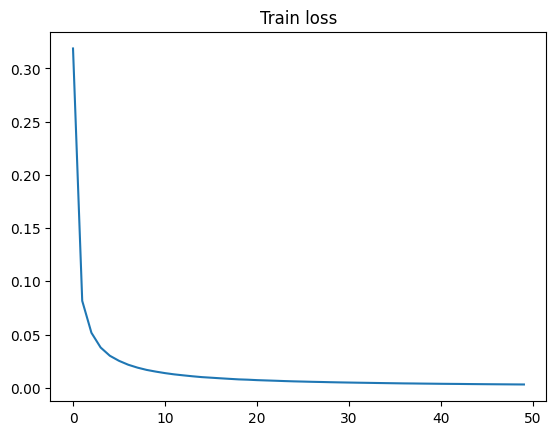

In [55]:
sns.lineplot(x=range(n_epoch), y=train_binary_loss)
plt.title('Train loss')
plt.show()

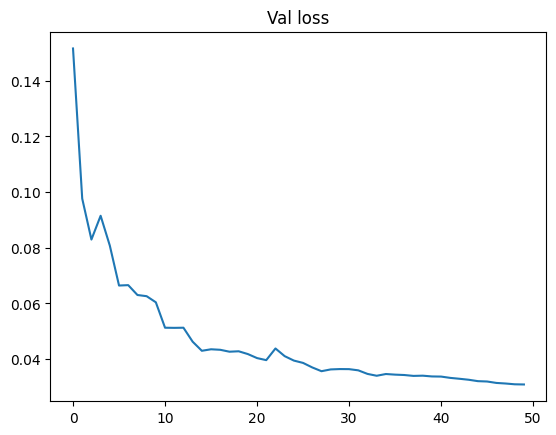

In [56]:
sns.lineplot(x=range(n_epoch), y=val_binary_loss)
plt.title('Val loss')
plt.show()

In [57]:
y_pred_binary_proba = nn_binary_model.predict(X_val_binary)
y_pred_binary_proba

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[3.2175815e-04],
       [9.7357976e-01],
       [1.2137236e-03],
       [9.9837488e-01],
       [9.8328191e-01],
       [9.9809325e-01],
       [9.7874862e-01],
       [9.8860115e-01],
       [9.9232376e-01],
       [1.0197480e-03],
       [3.4238016e-03],
       [3.3762625e-03],
       [6.4802892e-03],
       [7.4456848e-04],
       [6.9229188e-03],
       [9.7805327e-01],
       [9.9042439e-01],
       [6.3509229e-03],
       [7.8339793e-04],
       [6.2229345e-04],
       [2.0514771e-03],
       [9.9236989e-01],
       [4.2673368e-03],
       [6.6274597e-04],
       [9.8234499e-01],
       [9.7477859e-01],
       [2.4140118e-01],
       [9.4552112e-01],
       [8.5551001e-04],
       [1.0690388e-03],
       [4.8469221e-03],
       [1.4884865e-03],
       [9.3691825e-04],
       [9.7522861e-01],
       [1.4379653e-03],
       [8.1853231e-04],
       [9.9914873e-01],
       [9.7306025e-01],
       [9.0975529e-01],
       [9.9892879e-01],
       [2.0259265e-03],
       [5.076145

Acc = pred_true / (pred_true + pred_false) => all classes

Pre = pred_1 / (pred_1 + pred_0) => class 1

Rec = pred_1 / (pred_1 + label_1) => class 1

F1 => Pre <=> Rec

In [58]:
confidence_threshold = 0.5

In [59]:
y_pred_binary = np.where(y_pred_binary_proba > confidence_threshold, 1, 0)
y_pred_binary = y_pred_binary.squeeze()
y_pred_binary

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [60]:
print(classification_report(y_val_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.99      0.99        81

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



## 4.2. Multi-class classification data

In [61]:
n_units = 3
lr = 0.1 # 0.0001 => 0.01 => 0.1
batch_size = 2
n_epoch = 50

In [62]:
nn_multi_class_model = Sequential([
    Dense(input_dim=max_len_feature, units=n_units, activation='softmax')
])
nn_multi_class_model.summary()

/Users/minhhuunguyen/REPOSITORY/minhhuunguyen.github.io/posts/ai-lectures/venv/keras_tf_venv/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 3)              │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528 (2.06 KB)

 Trainable params: 528 (2.06 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
ce_loss = CategoricalCrossentropy()

In [64]:
sgd_opt = SGD(learning_rate=lr)

In [65]:
nn_multi_class_model.compile(loss=ce_loss, optimizer=sgd_opt)

In [66]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-10
)

In [67]:
os.makedirs('model_ckpts', exist_ok=True)
checkpoint = ModelCheckpoint('model_ckpts/model_multi_class_{epoch:02d}.h5')

In [68]:
history_multi_class = nn_multi_class_model.fit(
    x=X_train_multi_class,
    y=y_train_multi_class_one_hot,
    batch_size=batch_size,
    epochs=n_epoch,
    validation_data=(X_val_multi_class, y_val_multi_class_one_hot),
    shuffle=True,
    validation_batch_size=batch_size,
    class_weight={0:1, 1:5, 2:1},
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.3678

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8855 - val_loss: 0.3124 - learning_rate: 0.1000
Epoch 2/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2703

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.4138 - val_loss: 0.3249 - learning_rate: 0.1000
Epoch 3/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1253

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3165 - val_loss: 0.3917 - learning_rate: 0.1000
Epoch 4/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0800

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1868 - val_loss: 0.3353 - learning_rate: 0.0100
Epoch 5/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4301

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2093 - val_loss: 0.3099 - learning_rate: 0.0100
Epoch 6/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.2445 - val_loss: 0.2920 - learning_rate: 0.0100
Epoch 7/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0329

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.2323 - val_loss: 0.2811 - learning_rate: 0.0100
Epoch 8/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0757

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.2251 - val_loss: 0.2762 - learning_rate: 0.0100
Epoch 9/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0410

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.2503 - val_loss: 0.2753 - learning_rate: 0.0100
Epoch 10/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.2175 - val_loss: 0.2765 - learning_rate: 0.0100
Epoch 11/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1532

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.2366 - val_loss: 0.2713 - learning_rate: 0.0100
Epoch 12/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0464

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.1414 - val_loss: 0.2751 - learning_rate: 0.0100
Epoch 13/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0475

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.1694 - val_loss: 0.2771 - learning_rate: 0.0100
Epoch 14/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3440

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.2360 - val_loss: 0.2766 - learning_rate: 1.0000e-03
Epoch 15/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0545

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.1946 - val_loss: 0.2760 - learning_rate: 1.0000e-03
Epoch 16/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0570

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.1505 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 17/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.1386 - val_loss: 0.2759 - learning_rate: 1.0000e-04
Epoch 18/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0764

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.1954 - val_loss: 0.2759 - learning_rate: 1.0000e-05
Epoch 19/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.1528 - val_loss: 0.2759 - learning_rate: 1.0000e-05
Epoch 20/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.1579 - val_loss: 0.2759 - learning_rate: 1.0000e-06
Epoch 21/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0414

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.1538 - val_loss: 0.2759 - learning_rate: 1.0000e-06
Epoch 22/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0659

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.2188 - val_loss: 0.2759 - learning_rate: 1.0000e-07
Epoch 23/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.1413 - val_loss: 0.2759 - learning_rate: 1.0000e-07
Epoch 24/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0531

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.1105 - val_loss: 0.2759 - learning_rate: 1.0000e-08
Epoch 25/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0386

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.1648 - val_loss: 0.2759 - learning_rate: 1.0000e-08
Epoch 26/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1878

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.1164 - val_loss: 0.2759 - learning_rate: 1.0000e-09
Epoch 27/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3860

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.1643 - val_loss: 0.2759 - learning_rate: 1.0000e-09
Epoch 28/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0406

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.2767 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 29/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.1430 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 30/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0943

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.1359 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 31/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0718

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.1117 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 32/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0663

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.1222 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 33/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0401

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.1442 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 34/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0600

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.2264 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 35/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8607

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.3419 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 36/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.1390 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 37/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0773

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.1429 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 38/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0414

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.2079 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 39/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0485

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.2272 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 40/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4275

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.1823 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 41/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4204

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.2824 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 42/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.1537 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 43/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.1173 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 44/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.1502 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 45/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0780

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.1209 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 46/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1067

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.1429 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 47/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.1267 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 48/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5228

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.2591 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 49/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0523

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.1329 - val_loss: 0.2759 - learning_rate: 1.0000e-10
Epoch 50/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0300

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.1900 - val_loss: 0.2759 - learning_rate: 1.0000e-10


In [69]:
train_multi_class_loss = history_multi_class.history['loss']
# train_multi_class_loss

In [70]:
val_multi_class_loss = history_multi_class.history['val_loss']
# val_multi_class_loss

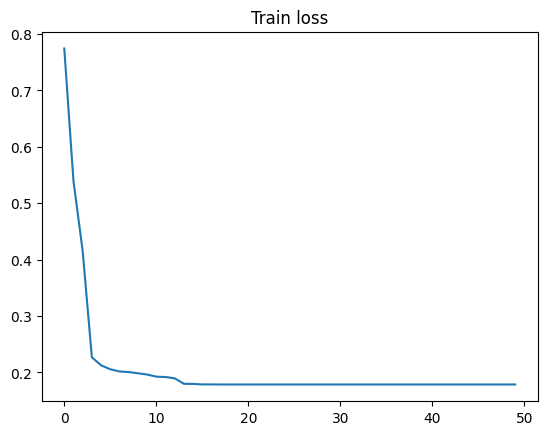

In [71]:
sns.lineplot(x=range(n_epoch), y=train_multi_class_loss)
plt.title('Train loss')
plt.show()

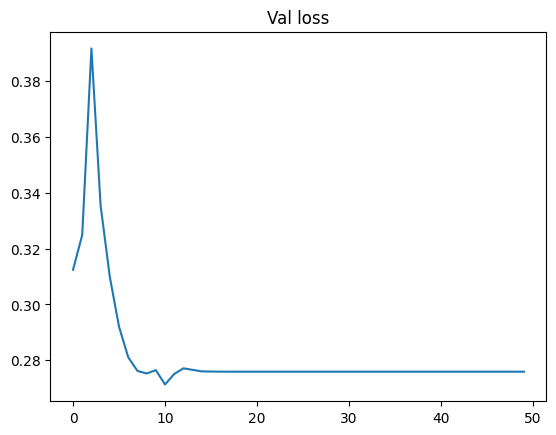

In [72]:
sns.lineplot(x=range(n_epoch), y=val_multi_class_loss)
plt.title('Val loss')
plt.show()

In [73]:
y_pred_multi_class_proba = nn_multi_class_model.predict(X_val_multi_class)
y_pred_multi_class_proba

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([[0.10976401, 0.40495065, 0.48528525],
       [0.9609087 , 0.01571763, 0.02337363],
       [0.02254565, 0.04188088, 0.9355735 ],
       [0.95641947, 0.01971179, 0.02386871],
       [0.00274795, 0.00360454, 0.9936475 ],
       [0.9595599 , 0.01558933, 0.02485076],
       [0.26949668, 0.01467794, 0.71582526],
       [0.00937183, 0.02690526, 0.9637228 ],
       [0.96043164, 0.01545486, 0.02411352],
       [0.01388418, 0.03367654, 0.95243925],
       [0.00956527, 0.01291077, 0.9775239 ],
       [0.01964078, 0.03537882, 0.94498044],
       [0.41828007, 0.09685803, 0.48486194],
       [0.03169153, 0.03121411, 0.9370944 ],
       [0.97334266, 0.0101394 , 0.01651792],
       [0.14000218, 0.32740358, 0.53259426],
       [0.07030252, 0.00506148, 0.92463595],
       [0.0197955 , 0.02879621, 0.9514083 ],
       [0.01504422, 0.00376212, 0.98119366],
       [0.981252  , 0.00728049, 0.01146756],
       [0.96809053, 0.01375688, 0.01815263],
       [0.05212485, 0.00333706, 0.94453806],
       [0.

In [74]:
y_pred_multi_class = np.argmax(y_pred_multi_class_proba, axis=1)
y_pred_multi_class

array([2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 2, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 0])

In [75]:
y_val_multi_class

array([2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0])

In [76]:
print(classification_report(y_val_multi_class, y_pred_multi_class))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.17      0.33      0.22         3
           2       0.93      0.91      0.92        56

    accuracy                           0.91       101
   macro avg       0.70      0.73      0.71       101
weighted avg       0.93      0.91      0.92       101

